In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [4]:
from ml_utils import print_report, score_model
from prepare_data import lag

In [5]:
df = pd.read_csv('data/los_angeles_weather_pm25.csv')
df = df.rename(mapper={'Unnamed: 0': 'DATE'}, axis='columns')
df = df.set_index(pd.to_datetime(df.DATE))
df = df[df.PM25 < 500]
df = df[df.PM25 > 0]

In [6]:
df['DOW'] = df.index.dayofweek
df['HOUR'] = df.index.hour
df['MONTH'] = df.index.month
df['WEEKDAY'] = df.DOW.between(0, 4)
df = lag(df, 'PM25', lags=[1, 2, 3, 4, 5, 6, 12, 24])

In [7]:
df = df.dropna()

In [8]:
weather = ['TMP', 'DEW', 'SPD', 'SLP', 'DIR']
features = [weather, weather + ['DOW', 'MONTH', 'HOUR'], weather + ['DOW', 'MONTH', 'HOUR', 'PM25_24'], weather + ['DOW', 'MONTH', 'HOUR', 'PM25_12'], weather + ['DOW', 'MONTH', 'HOUR', 'PM25_6'], weather + ['DOW', 'MONTH', 'HOUR', 'PM25_1']]
labels = ['Weather', 'W + time', 'W + t + PM25 24 hour lag', 'W + t + PM25 12 hour lag', 'W + t + PM25 6 hour lag', 'W + t + PM25 1 hour lag']

In [15]:
feat = features[-1]
X = df[feat].values
y = df['PM25'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
est = RandomForestRegressor()
param_grid = {'n_estimators': [10, 50, 100],
             'max_depth': [2, 3, 4, 5, 10]}
cv = GridSearchCV(estimator=est, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
cv.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 50, 100], 'max_depth': [2, 3, 4, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [16]:
print(cv.best_params_)

{'n_estimators': 100, 'max_depth': 10}


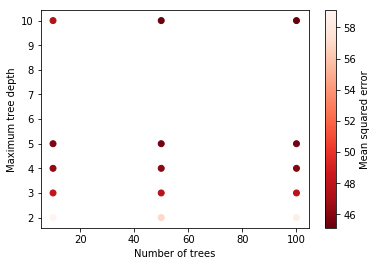

In [37]:
x = [p['n_estimators'] for p in cv.cv_results_['params']]
y = [p['max_depth'] for p in cv.cv_results_['params']]
s = [-s for s in cv.cv_results_['mean_test_score']]
paths = plt.scatter(x, y, c=s, cmap='Reds_r')
plt.colorbar(paths, label='Mean squared error')
plt.xlabel('Number of trees')
plt.ylabel('Maximum tree depth')
plt.savefig('fig/crossval.png', dpi=300, bbox_inches='tight')

In [ ]:
models = [LinearRegression(), SVR(kernel='linear'), RandomForestRegressor(n_estimators=10, max_depth=5)]
features = [weather, weather + ['DOW', 'MONTH', 'HOUR'], weather + ['DOW', 'MONTH', 'HOUR', 'PM25_24'], weather + ['DOW', 'MONTH', 'HOUR', 'PM25_6'], weather + ['DOW', 'MONTH', 'HOUR', 'PM25_1']]
for feat in features:
    for model in models:
        X = df[feat].values
        y = df['PM25'].values
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
        n, p = X_train.shape
        f = (n - 1) / (n - p - 1)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print_report(y_test, y_pred, p, f)

In [ ]:
model = RandomForestRegressor(n_estimators=100, max_depth=10)
feat = features[-1] + ['volume']
X = df[feat].values
y = df['PM25'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
score_model(y_test, y_pred, p +1)

In [ ]:
plt.plot(y_test, y_pred, 'k.')
ymax = max(y_test.max(), y_pred.max())
plt.plot([0, ymax], [0, ymax], 'b-')
plt.xlim([0, ymax])
plt.ylim([0, ymax])
plt.xlabel('True PM$_{2.5}$ [$\mu$g m$^{-3}$]', fontsize=12)
plt.ylabel('Predicted PM$_{2.5}$ [$\mu$g m$^{-3}$]', fontsize=12)
plt.savefig('fig/rf_comparison.png', dpi=300, bbox_inches='tight')

In [ ]:
df2 = pd.read_csv('data/Traffic_Count__Data.csv')
df2 = df2.set_index(pd.to_datetime(df2['Count Date']))
df2 = df2.groupby(pd.TimeGrouper('D')).mean()
df2.columns = ['volume']

In [ ]:
df2 = df2.resample('H').ffill()

In [ ]:
df3 = pd.concat([df, df2], axis='columns')

In [ ]:
ax = sns.regplot(x='volume', y='PM25', data=df3)
ax.set_xlabel('Daily traffic volume')
ax.set_ylabel('PM$_{2.5}$')
plt.savefig('fig/traffic.png')

In [ ]:
df3 = df3.dropna()